In [17]:
import cv2
import math
import glob
import inspect
import json
import mlflow
import torch
import os
import time
import sys

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [18]:
BATCH_SIZE = 64
NUM_WORKERS = 0
DEVICE = "cuda"
N_EPOCHS = 100
LR = 1e-4

ROOT_PATH = "../data"
FILE_NAME = os.path.join(ROOT_PATH, "bill_detection.pth")

In [47]:
checkpoint = torch.load(FILE_NAME)

In [48]:
# checkpoint = None

In [21]:
class CustomDataset(Dataset):
    def __init__(self, root, train=True):
        self.root = root

        with open(os.path.join(self.root, "data.json"), "r") as f:
            data = json.load(f)

        self.elements = data["entries"]
        
        present_elements = []
        for element in self.elements:
            filename = element["filename"]
            if not os.path.isfile(filename):
                continue
            else:
                present_elements.append(element)
        self.elements = present_elements
        
        self.visible_categories = {"yes": 0, "no": 1}
        self.text_categories = {"yes": 0, "no": 1}

        element = self.elements[0]
        filename = element["filename"]
        img = cv2.imread(filename)
        self.h, self.w, c = img.shape

        n_train = int(len(self) * 0.8)

        if train:
            self.elements = self.elements[:n_train]
        else:
            self.elements = self.elements[n_train:]

    def __len__(self):
        return len(self.elements)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()

        element = self.elements[idx]

        label_visible = element["label_visible"]
        label_visible = np.array(self.visible_categories[label_visible], dtype=np.int64)
        
        label_text = element["label_text"]
        label_text = np.array(self.text_categories[label_text], dtype=np.int64)
        
        filename = element["filename"]
        
        raw_coord = element["coord"]
        coord = raw_coord.replace(")", "")
        coord = coord.replace("(", "")
        xl, yl, xu, yu = coord.split(",")
        xl = int(xl)
        yl = int(yl)
        xu = int(xu)
        yu = int(yu)
        coords = np.array([xl, yl, xu, yu], dtype=np.float32)

        split_char = "/"
        fileparts = filename.split(split_char)
        filename = fileparts[-1].split(".")[0] + f"_{xl}_{yl}_{xu}_{yu}.jpg"
        filename = os.path.join(split_char.join(fileparts[:-1]), filename)
        filename = filename.split(split_char)[-1]
        filename = os.path.join(self.root, f"patches/{filename}")
        
        patch = cv2.imread(filename)
        patch[:, :, [0, 1, 2]] = patch[:, :, [2, 1, 0]]
        patch = torch.from_numpy(patch) / 255
        patch = patch.permute(2, 0, 1)
        patch = patch.to(torch.float32)

        sample = dict()
        sample["patch"] = patch
        sample["coords"] = coords
        sample["label_visible"] = label_visible
        sample["label_text"] = label_text

        return sample

In [22]:
train_dataset = CustomDataset(ROOT_PATH, train=True)
test_dataset = CustomDataset(ROOT_PATH, train=False)
HEIGHT = train_dataset.h
WIDTH = train_dataset.w
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True, num_workers=NUM_WORKERS)
print("Train:", len(train_dataset))
print("Test:", len(test_dataset))

Train: 755
Test: 189


In [23]:
print("HEIGHT", HEIGHT)
print("WIDTH", WIDTH)

HEIGHT 4032
WIDTH 3024


In [24]:
with torch.no_grad():
    batch = next(iter(train_loader))
    coords = batch["coords"]
    patches = batch["patch"]
    print(coords.shape)
    print(patches.shape)

torch.Size([64, 4])
torch.Size([64, 3, 256, 256])


In [25]:
count_visible = np.array([0, 0])
count_text = np.array([0, 0])
for i, element in enumerate(train_dataset):
    print(f"\r{i}|{len(train_dataset)}", end="")
    visible = element["label_visible"]
    count_visible[visible] += 1
    text = element["label_text"]
    count_text[text] += 1
weights_visible = torch.from_numpy(count_visible / count_visible.sum()).to(DEVICE).to(torch.float32)
weights_text = torch.from_numpy(count_text / count_text.sum()).to(DEVICE).to(torch.float32)
print()
print(count_visible)
print(weights_visible)
print(count_text)
print(weights_text)

754|755
[421 334]
tensor([0.5576, 0.4424], device='cuda:0')
[333 422]
tensor([0.4411, 0.5589], device='cuda:0')


In [43]:
def train():
    N = len(train_loader)
    sum_loss_visible = 0
    sum_loss_text = 0
    sum_loss = 0
    count = 0
    for n_epoch in range(N_EPOCHS):
        for n, batch in enumerate(train_loader):
                
            patch = batch["patch"].to(DEVICE)
            label_visible = batch["label_visible"].to(DEVICE)
            label_text = batch["label_text"].to(DEVICE)

            visible, text = model(patch)
            
            loss_visible = F.cross_entropy(visible, label_visible, weight=weights_visible)
            loss_text = F.cross_entropy(text, label_text, weight=weights_text)
            loss = loss_visible + loss_text

            loss.backward()

            sum_loss_visible += loss_visible.item()
            sum_loss_text += loss_text.item()
            sum_loss += loss.item()
            count += 1

            mlflow.log_metric("train_loss", sum_loss / count, step=n_epoch * len(train_loader) + n, synchronous=False)
            mlflow.log_metric("train_loss_visible", sum_loss_visible / count, step=n_epoch * len(train_loader) + n, synchronous=False)
            mlflow.log_metric("train_loss_text", sum_loss_text / count, step=n_epoch * len(train_loader) + n, synchronous=False)

            print(f"\r{n_epoch + 1:03d}|{N_EPOCHS:03d}, {n + 1:04d}|{N:04d}, loss: {sum_loss / count:.05f}, loss_visible: {sum_loss_visible / count:.05f}, loss_text: {sum_loss_text / count:.05f}", end="")

            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        if (n_epoch + 1) % 5 == 0:
            print()
            print()
            train_acc = eval(train_loader, "TRAIN")
            test_acc = eval(test_loader, "TEST")
            print()        
            mlflow.log_metric("train_acc", train_acc, step=n_epoch, synchronous=False)
            mlflow.log_metric("test_acc", test_acc, step=n_epoch, synchronous=False)

        sum_loss_visible = 0
        sum_loss_text = 0
        sum_loss = 0
        count = 0
@torch.no_grad
def eval(loader, label):
    acc = 0
    count = 0
    for i, batch in enumerate(loader):
        patch = batch["patch"].to(DEVICE)
        label_visible = batch["label_visible"]
        label_text = batch["label_text"]
        
        visible, text = model(patch)

        visible = visible.detach().cpu().numpy().argmax(axis=1)
        label_visible = label_visible.detach().cpu().numpy()

        text = text.detach().cpu().numpy().argmax(axis=1)
        label_text = label_text.detach().cpu().numpy()
        
        acc += sum([pred == gt for pred, gt in zip(visible, label_visible)]) / len(visible)
        acc += sum([pred == gt for pred, gt in zip(text, label_text)]) / len(text)
        count += 2

        print(f"\r{label}, {i + 1}|{len(loader)}", end="")
    print()
    print(f"Eval {label}, Accuracy: {(acc / count) * 100:0.2f}%")
    return (acc / count) * 100
@torch.no_grad
def test_model_config():
    batch = next(iter(train_loader))
    patch = batch["patch"].to(DEVICE)
    label_visible = batch["label_visible"].to(DEVICE)
    label_text = batch["label_text"].to(DEVICE)
    print(patch.shape)
    print(label_visible.shape)
    print(label_text.shape)
    visible, text = model(patch)
    print(visible.shape)
    print(text.shape)
    loss_visible = F.cross_entropy(visible, label_visible, weight=weights_visible)
    print(loss_visible)
    loss_text = F.cross_entropy(text, label_text, weight=weights_text)
    print(loss_text)
    loss = loss_visible + loss_text
    print(loss)
    print()
@torch.no_grad
def generate_maps(loader):
    with open(os.path.join(ROOT_PATH, "data.json"), "r") as f:
        data = json.load(f)

    elements = data["entries"]
    while True:
        idx = np.random.randint(0, len(elements))
        element = elements[idx]
        filename = element["filename"]
        if os.path.isfile(filename):
            break

    raw_img = cv2.imread(filename)
    H, W, c = raw_img.shape
    raw_img[:, :, [0, 1, 2]] = raw_img[:, :, [2, 1, 0]]
    img = torch.from_numpy(raw_img) / 255
    img = img.permute(2, 0, 1)

    nh = 6
    nw = 4
    ph, pw = 256, 256
    ph_step = ph // nh
    pw_step = pw // nw

    coords = []
    patches = []
    for xl in range(0, W - pw, pw_step):
        for yl in range(0, H - ph, ph_step):
            xu = xl + pw
            yu = yl + ph
            print(f"\r{xl}:{xu}, {yl}:{yu}", end="")
            patch = img[:, yl:yu, xl:xu]
            patch = patch[None, :]
            coords.append((xl, xu, yl, yu))
            patches.append(patch)
            
    patches = torch.cat(patches, dim=0)

    BS = 128
    N = len(patches) // BS
    visibles = []
    texts = []
    for i in range(0, len(patches), BS):
        patch = patches[i:i + BS]
        patch = patch.to(DEVICE)

        visible, text = model(patch)
        patch = patches.detach().cpu()

        visible = visible.detach().cpu().numpy().tolist()
        text = text.detach().cpu().numpy().tolist()
        
        visibles.extend(visible)
        texts.extend(text)
        
    visibles = np.asarray(visibles)
    texts = np.asarray(texts)
    
    visibles = np.asarray(visibles).argmax(axis=1)
    texts = np.asarray(texts).argmax(axis=1)

    map_visible = np.ones([H, W, 2])
    map_text = np.ones([H, W, 2])
    for i, (xl, xu, yl, yu) in enumerate(coords):
        map_visible[yl:yu, xl:xu, visibles[i]] += 1
        map_text[yl:yu, xl:xu, texts[i]] += 1

    map_visible = map_visible[:, :, 0] / map_visible.sum(axis=-1)
    map_visible[map_visible > 0.5] = 1.0
    map_visible[map_visible <= 0.5] = 0.0
    
    map_text = map_text[:, :, 0] / map_text.sum(axis=-1)
    map_text[map_text > 0.5] = 1.0
    map_text[map_text <= 0.5] = 0.0

    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    axes[0].imshow(raw_img)
    axes[0].set_title("img")
    axes[1].imshow(map_visible)
    axes[1].set_title("visible")
    axes[2].imshow(map_text)
    axes[2].set_title("text")
    plt.show()

In [44]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
                                     nn.ReLU(),
                                     nn.AvgPool2d(2, 2),
                                     nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
                                     nn.ReLU(),
                                     nn.AvgPool2d(2, 2),
                                     nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
                                     nn.ReLU())

        self.dropout = nn.Dropout(p=0.25)

        self.out = nn.Sequential(nn.Linear(1024, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, 2 + 2))

    def forward(self, x):
        
        x = self.encoder(x)
        latent = x.view(x.shape[0], -1)
        latent = self.dropout(latent)
        x = self.out(latent)
        visible = F.softmax(x[:, :2], dim=-1)
        text = F.softmax(x[:, 2:], dim=-1)
        
        return visible, text

In [49]:
model = Model().to(DEVICE)

if checkpoint is not None:
    model.load_state_dict(checkpoint["model_state_dict"])

scaler = torch.cuda.amp.GradScaler(enabled=True)
if checkpoint is not None:
    scaler.load_state_dict(checkpoint["scaler_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
if checkpoint is not None:
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

n_model_parameters = sum(p.numel() for p in model.parameters())
print(f"Model: {n_model_parameters:,}".replace(",", "."))
print()

test_model_config()

mlflow.set_tracking_uri(uri="http://localhost:8080")
_ = mlflow.set_experiment(f"Classifiy patches from bill images.")

Model: 11.325.668

torch.Size([64, 3, 256, 256])
torch.Size([64])
torch.Size([64])
torch.Size([64, 2])
torch.Size([64, 2])
tensor(0.3991, device='cuda:0')
tensor(0.3251, device='cuda:0')
tensor(0.7242, device='cuda:0')



In [ ]:
run_id = None
with mlflow.start_run(run_id=run_id):
    train()

In [30]:
train_acc = eval(train_loader, "TRAIN")
test_acc = eval(test_loader, "TEST")

TRAIN, 12|12
Eval TRAIN, Accuracy: 95.75%
TEST, 3|3
Eval TEST, Accuracy: 95.48%


In [31]:
torch.save({"model_state_dict": model.state_dict(), 
            "optimizer_state_dict": optimizer.state_dict(), 
            "scaler_state_dict": scaler.state_dict()}, FILE_NAME)

2752:3008, 3738:3994

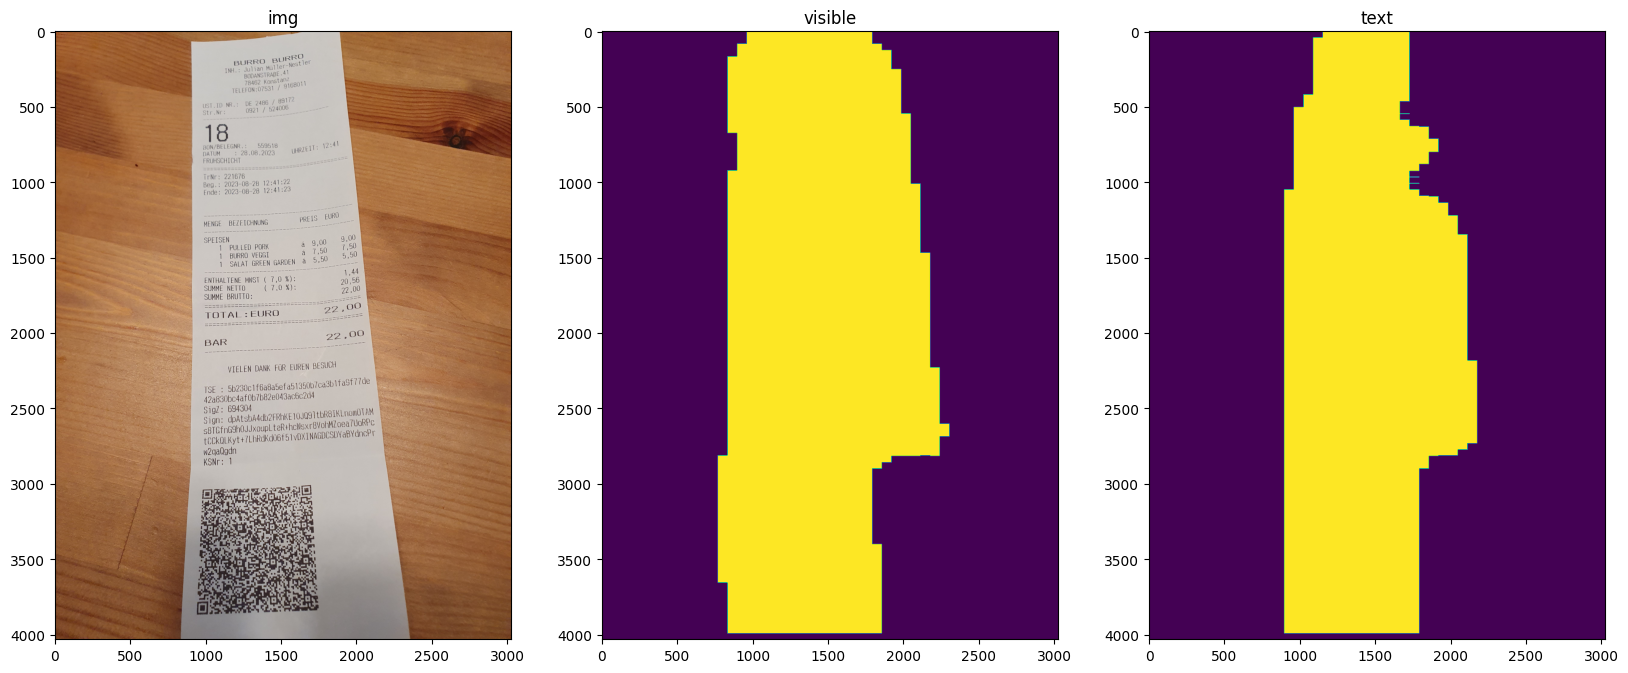

In [53]:
generate_maps(train_loader)